# Finding Problem Spots in 3' UTRs

We try to find those transcripts where we have an unexpected accumulation of reads (in the shape of a peak) in theor 3' UTR. Typically, there is a noncoding RNA or some repeat region overlapping with these peaks.

In this notebook, we are writing the sequences, to be filtered out, in a separate fasta file. We will simply append this fasta file to our existing reference fasta to assemble the actual filter for our pipeline.

**We are only taking ITP experiments done after 2019!**

  * 20201104-ITP-100-5mM-50-1                  
  * 20201209-ITP-100-5mM-6  
  * 20210131-ITP-100-5mM-50_diluted-1  
  

In [1]:
import ribopy

import matplotlib

from matplotlib import pyplot as plt

from ribopy.core.get_gadgets import get_region_boundaries

import pandas as pd
import numpy as np

from functools import partial

import gzip

%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 5]

In [2]:
colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00']

In [3]:
ribo_file = "../../human-itp_v1.ribo"
myribo    = ribopy.Ribo(ribo_file, alias=ribopy.api.alias.apris_human_alias)

In [4]:
myribo.print_info()

Ribo File Info:
---------------
Ribo File Version : 1.0
RiboPy Version    : 0.0.1
Creation Time     : 2021-05-26 12:59:15
Reference         : appris-v1
Min Read Length   : 15
Max Read Length   : 40
Metagene Radius   : 50
Left Span         : 35
Right Span        : 10

Experiments:
------------ 
Name                                  Reads  Coverage  RNA-Seq  Metadata
20180726-ITP-10-1                    100377         *                   
20180726-ITP-10-2                    116460         *                   
20180726-ITP-100-1                   172872         *                   
20180726-ITP-100-2                   253531         *                   
20180726-ITP-1000-1                  449808         *                   
20180726-ITP-1000-2                  433945         *                   
20180726-Kit-500k-1                  917372         *                   
20180726-Kit-500k-2                 2289591         *                   
20180726-Kit-500k-3                 1008966     

In [5]:
LENGTH_MIN = 29
LENGTH_MAX = 34

In [6]:
experiments_stanford_itp = ["20180726-ITP-10-1",   "20180726-ITP-10-2", 
                            "20180726-ITP-100-1",  "20180726-ITP-100-2",
                            "20180726-ITP-1000-1", "20180726-ITP-1000-2"]

experiments_ut_itp = ["20201104-ITP-100-5mM-50-1", 
                      "20201209-ITP-100-5mM-6",
                      "20210131-ITP-100-5mM-50_diluted-1"]

experiments_itp = experiments_ut_itp

In [7]:
from ribopy.core.get_gadgets import get_region_boundaries

def rename(x):
    return x.split("|")[4]


def get_coverage(ribo, 
                 experiment,
                 range_lower = 0,
                 range_upper = 0,
                 alias       = False,
                 multiplier  = 1):
    """
    NOTE THAT THIS FUNCTION RETURNS A TUPLE!!!
    
    Returns a pair: (dataframe, coverage_dict)
    
    In the dataframe, the last column 
    has the coverage density of a given transcript.
    The normalized covarage is defined by
    (#total_reads / #transcript_length) * 1000000
    
    coverage_dict: This is the output of the function "get_coverage"
    of the ribo object. It contains the coverage values of each gene 
    at nucleotide resolution.

    """
    
    coverage_dict = ribo.get_coverage(experiment  = experiment,
                                      range_lower = range_lower, 
                                      range_upper = range_upper,
                                      alias       = alias)
    
    region_boundaries = get_region_boundaries(ribo._handle)
    
    transcript_names     = coverage_dict.keys()
    transcript_coverages = coverage_dict.values()
    transcript_total     = tuple( map( np.sum, transcript_coverages ) )
    transcript_lengths   = tuple( map(len, transcript_coverages) )
    normalized_coverage  = np.divide(transcript_total , transcript_lengths) * multiplier
    start_sites          = tuple( map( lambda x: x[1][0], region_boundaries ) )
    stop_sites           = tuple( map( lambda x: x[1][1], region_boundaries ) )
    
    # We also add normalized cds coverage
    cds_data = zip( start_sites, stop_sites, transcript_coverages )
    norm_cds = tuple( map( lambda x:  
                              (np.sum( x[2][x[0]:x[1]] ) / (x[1] - x[0]) )* multiplier,
                      cds_data) )
    
    result = pd.DataFrame(data = { "total"     :  transcript_total, 
                                   "length"    :  transcript_lengths,
                                   "cds_start" :  start_sites,
                                   "cds_stop"  :  stop_sites,
                                   "norm_cds"  :  norm_cds,
                                   "norm_cov"  :  normalized_coverage}, 
                          index = transcript_names) 
    
    return( (result, coverage_dict))

In [8]:
coverages = { e: get_coverage(
                     ribo        = myribo, 
                     experiment  = e,
                     range_lower = LENGTH_MIN,
                     range_upper = LENGTH_MAX,
                     alias       = rename)\
                 for e in myribo.experiments }

In [9]:
def plot_gene(experiment_name, gene_name, highlight = False):
    gene_coverage = coverages[experiment_name][1][gene_name]

    cds_start = coverages[experiment_name][0].loc[gene_name]["cds_start"]
    cds_end   = coverages[experiment_name][0].loc[gene_name]["cds_stop"]

    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = [15, 5]
    plt.plot(gene_coverage, color = '#D55E00')
    plt.title(gene_name)
    
    if highlight:
        ax.fill_between( highlight ,y1 = max( gene_coverage ), color = "#BF5700", alpha = 0.2)
        
    ax.fill_between([cds_start, cds_end], y1 = max( gene_coverage ), alpha = 0.2);
    return fig

## Length Distribution

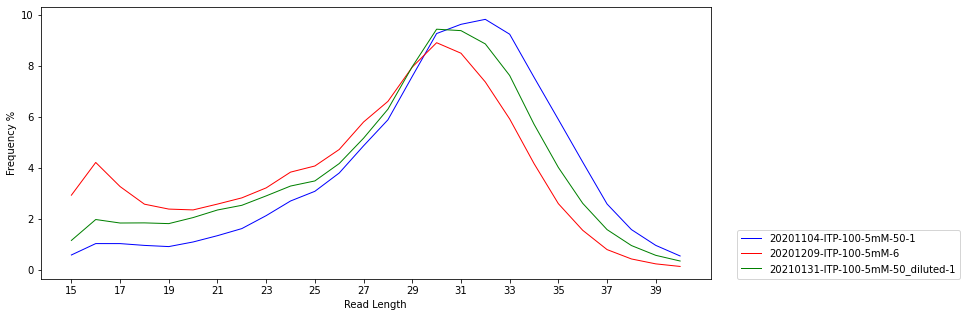

In [10]:
myribo.plot_lengthdist(region_type="CDS",experiments=experiments_itp, normalize = "True")

In [11]:
utr3_total_region_counts = myribo.get_region_counts(
                              experiments    = experiments_itp,
                              region_name    = "UTR3",
                              range_lower    = LENGTH_MIN,
                              range_upper    = LENGTH_MAX,
                              alias          = True,                            
                              sum_lengths    = True,
                              sum_references = False)

In [12]:
utr3_total_region_counts

,20201104-ITP-100-5mM-50-1,20201209-ITP-100-5mM-6,20210131-ITP-100-5mM-50_diluted-1
transcript,,,
OR4F5-201,0,0,0
OR4F29-201,0,0,0
OR4F16-201,0,0,0
SAMD11-202,0,0,0
NOC2L-201,16,4,8
...,...,...,...
MT-CO2-201,0,0,0
MT-ATP8-201,0,0,0
MT-ATP6-201,0,0,0


## Distribution of UTR3 Counts

The x-axis corresponds to different genes and the y-axis corresponds to the total number of reads in the 3' UTR. The peaks are outliers and need to be investigated.

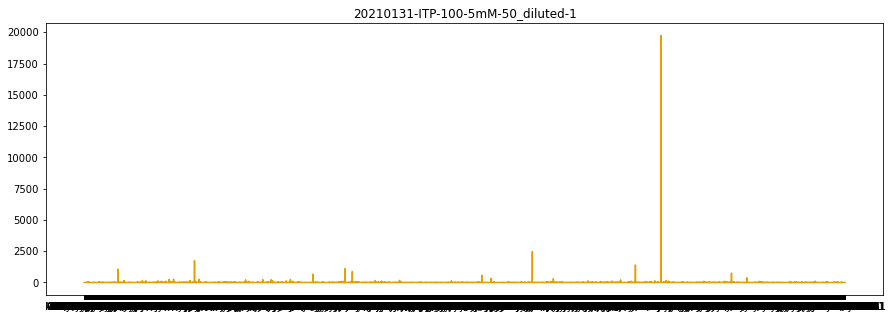

In [13]:
this_experiment = "20210131-ITP-100-5mM-50_diluted-1"

x1 = utr3_total_region_counts[this_experiment]
plt.plot(x1, color = colors[0]);
plt.title(this_experiment);

In [14]:
this_experiment = "20210131-ITP-100-5mM-50_diluted-1"

top_counts_diluted_1 = utr3_total_region_counts[this_experiment].sort_values(ascending=False)[:50]
top_counts_diluted_1

transcript
CTC1-214        19755
ST8SIA1-203      2469
ATP5MC3-201      1729
PAGR1-201        1396
KPNA5-202        1100
RPAP2-203        1050
SOD2-210          877
ZNF66-201         753
ZNF354B-201       667
MTRNR2L8-201      576
DMWD-201          372
OR5AS1-202        310
C12orf45-204      293
REL-201           267
CFLAR-201         253
MEMO1-201         249
NSA2-205          233
SULT1B1-201       229
FAM241A-201       215
TMEM212-201       206
LRRK1-201         205
YIPF4-201         187
HOOK3-201         171
MTRNR2L1-201      167
FRK-201           164
TRIM56-201        157
ORC4-214          149
SIKE1-201         148
QRFPR-202         141
SFT2D2-201        136
MAB21L3-201       136
RGS16-201         134
ZNF485-202        130
OR1A1-203         130
RDH11-201         128
PCNX2-201         127
NNT-201           124
TMEM107-204       117
PAQR5-202         114
CEP41-201         112
PIAS2-204         111
TMC5-203          106
INTU-201          103
ATAD5-201         100
IL1RAPL1-202       99

In [15]:
np.sum(utr3_total_region_counts[this_experiment] )

65106

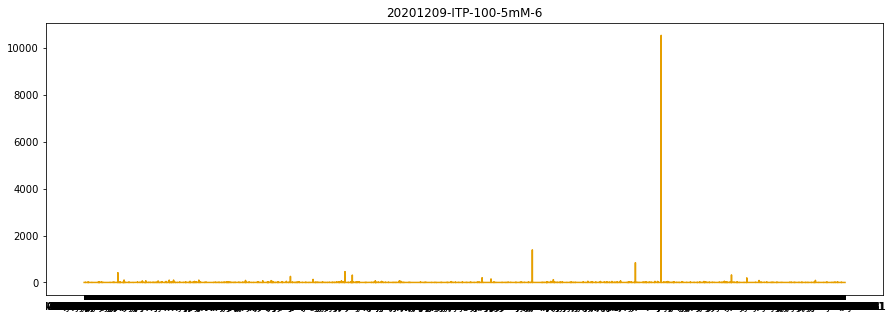

In [16]:
this_experiment = "20201209-ITP-100-5mM-6"

x1 = utr3_total_region_counts[this_experiment]
plt.plot(x1, color = colors[0]);
plt.title(this_experiment);

In [17]:
this_experiment = "20201209-ITP-100-5mM-6"

utr3_total_region_counts[this_experiment][ utr3_total_region_counts[this_experiment] > 1000 ]

top_counts_6 = utr3_total_region_counts[this_experiment].sort_values(ascending=False)[:50]
top_counts_6

transcript
CTC1-214        10537
ST8SIA1-203      1390
PAGR1-201         843
KPNA5-202         462
RPAP2-203         417
ZNF66-201         322
SOD2-210          316
NSA2-205          259
MTRNR2L8-201      202
DMWD-201          196
OR5AS1-202        151
ZNF354B-201       131
C12orf45-204      120
MAB21L3-201       106
REL-201           104
CFLAR-201         102
MEMO1-201         101
IL1RAPL1-202       91
TMEM212-201        88
BRSK1-201          85
FAM241A-201        79
HOOK3-201          76
SULT1B1-201        74
LRRK1-201          72
RGS16-201          72
TRIM56-201         72
BACH2-201          71
SFT2D2-201         67
PCNX2-201          66
FAM126B-202        64
FRK-201            58
CACNA1A-201        56
RDH11-201          54
ORC4-214           52
KAT6A-201          52
NNT-201            51
QRFPR-202          50
CEP41-201          49
ATP5MC3-201        48
PLAG1-201          48
OR1A1-203          48
NUDT4-201          47
ABCC9-201          46
DHX33-201          45
NCOA1-204          45

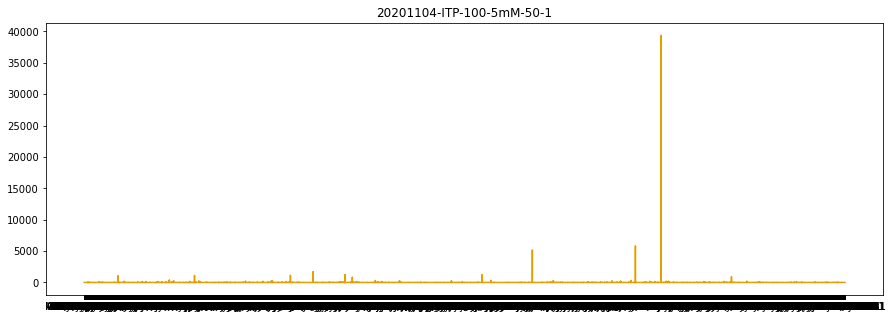

In [18]:
this_experiment = "20201104-ITP-100-5mM-50-1"

x1 = utr3_total_region_counts[this_experiment]
plt.plot(x1, color = colors[0]);
plt.title(this_experiment);

In [19]:
this_experiment = "20201104-ITP-100-5mM-50-1"

top_counts_50 = utr3_total_region_counts[this_experiment].sort_values(ascending=False)[:50]
top_counts_50

transcript
CTC1-214        39380
PAGR1-201        5824
ST8SIA1-203      5177
ZNF354B-201      1726
KPNA5-202        1248
MTRNR2L8-201     1242
NSA2-205         1142
ATP5MC3-201      1124
RPAP2-203        1082
ZNF66-201         913
SOD2-210          850
YIPF4-201         383
OR5AS1-202        347
TMC5-203          340
MEMO1-201         333
C12orf45-204      326
TRIM56-201        316
QRFPR-202         314
TMEM107-204       291
HOOK3-201         290
ZNF485-202        273
REL-201           268
PAQR5-202         265
CFLAR-201         257
LRRK1-201         234
TMEM212-201       233
DMWD-201          212
MTRNR2L1-201      209
FAM241A-201       204
ATAD5-201         200
PLCG2-207         197
MAB21L3-201       189
SULT1B1-201       186
FRK-201           165
ORC4-214          164
SFT2D2-201        157
CEP41-201         156
NNT-201           155
PIAS2-204         153
CACNA1A-201       149
RGS16-201         148
OR1A1-203         146
FAM126B-202       145
SIKE1-201         134
PCNX2-201         129

In [20]:
np.sum(top_counts_diluted_1)

36877

In [21]:
np.sum(top_counts_diluted_1[:10])

30372

In [22]:
np.sum(top_counts_diluted_1[:10]) / np.sum(top_counts_diluted_1)

0.8236027876454158

In [23]:
np.sum(top_counts_6)

17699

In [24]:
np.sum(top_counts_6[:10])

14944

In [25]:
np.sum(top_counts_50)

67990

In [26]:
np.sum(top_counts_50[:10])

58858

## Top 7 Common Transcripts

In [27]:
slice_cap = 10
top_7_transcripts = \
    set( top_counts_diluted_1[:slice_cap].index ).\
        intersection( set( top_counts_6[:slice_cap].index ).\
        intersection( set( top_counts_50[:slice_cap].index  ) ) ) 
top_7_transcripts

{'CTC1-214',
 'KPNA5-202',
 'MTRNR2L8-201',
 'PAGR1-201',
 'RPAP2-203',
 'ST8SIA1-203',
 'ZNF66-201'}

## Top 40 Transcripts

In [28]:
slice_cap = 50
top_40_transcripts = \
    set( top_counts_diluted_1[:slice_cap].index ).\
        intersection( set( top_counts_6[:slice_cap].index ).\
        intersection( set( top_counts_50[:slice_cap].index  ) ) ) 
top_40_transcripts

{'ATP5MC3-201',
 'BRSK1-201',
 'C12orf45-204',
 'CACNA1A-201',
 'CEP41-201',
 'CFLAR-201',
 'CTC1-214',
 'DMWD-201',
 'FAM126B-202',
 'FAM241A-201',
 'FRK-201',
 'HOOK3-201',
 'KPNA5-202',
 'LRRK1-201',
 'MAB21L3-201',
 'MEMO1-201',
 'MTRNR2L8-201',
 'NNT-201',
 'NSA2-205',
 'OR1A1-203',
 'OR5AS1-202',
 'ORC4-214',
 'PAGR1-201',
 'PAQR5-202',
 'PCNX2-201',
 'PIAS2-204',
 'QRFPR-202',
 'RDH11-201',
 'REL-201',
 'RGS16-201',
 'RPAP2-203',
 'SFT2D2-201',
 'SOD2-210',
 'ST8SIA1-203',
 'SULT1B1-201',
 'TMEM212-201',
 'TRIM56-201',
 'YIPF4-201',
 'ZNF354B-201',
 'ZNF66-201'}

In [29]:
len(top_7_transcripts)

7

## CTC1 Plots

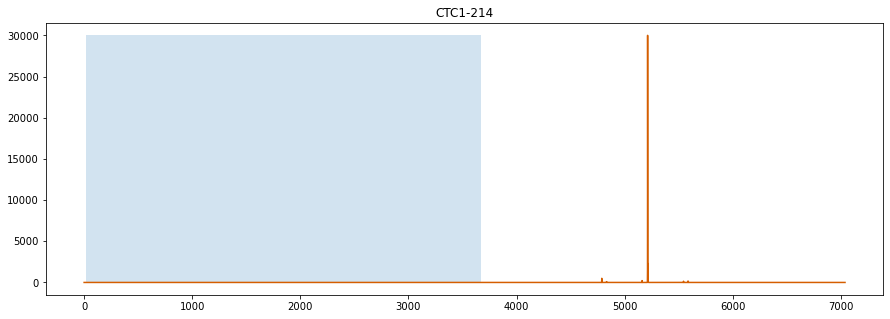

In [30]:
plot_gene(experiment_name = "20201104-ITP-100-5mM-50-1", gene_name = "CTC1-214") ;

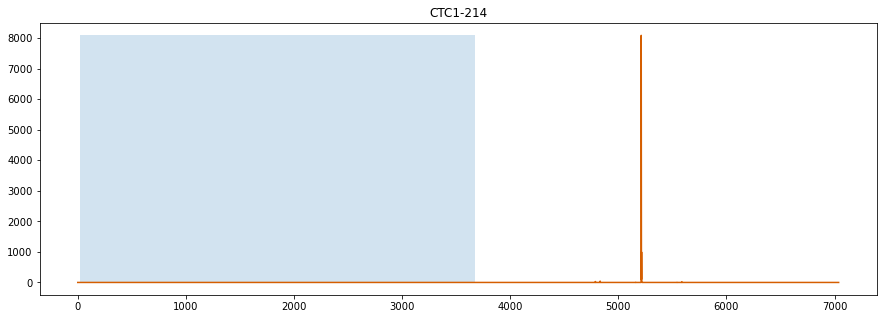

In [31]:
plot_gene(experiment_name = "20201209-ITP-100-5mM-6", gene_name = "CTC1-214") ;

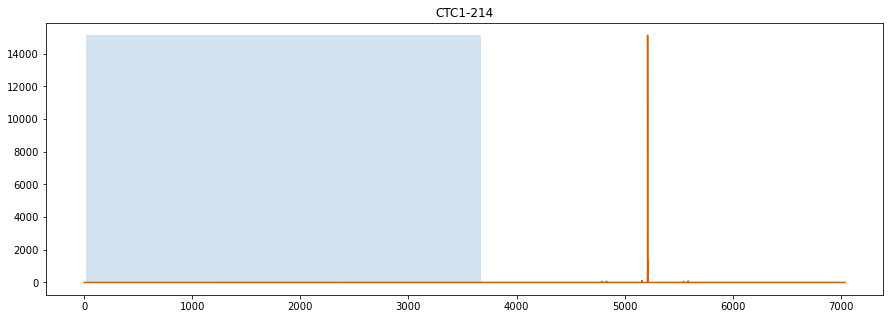

In [32]:
plot_gene(experiment_name = "20210131-ITP-100-5mM-50_diluted-1", gene_name = "CTC1-214") ;

## Region Counts

In [33]:
def get_percentages(myribo, excluded_transcripts = []):
    """
    Returns CDS percentages after excluding the given set of genes
    """

    get_generic_region_counts = partial(myribo.get_region_counts, 
                                          experiments    = experiments_itp,
                                          range_lower    = LENGTH_MIN,
                                          range_upper    = LENGTH_MAX,
                                          alias          = True,
                                          sum_lengths    = True,
                                          sum_references = False)

    cds_total_region_counts  = get_generic_region_counts(region_name    = "CDS")
    utr3_total_region_counts = get_generic_region_counts(region_name    = "UTR3")
    utr5_total_region_counts = get_generic_region_counts(region_name    = "UTR5")

    selected_transcripts     = list(set( cds_total_region_counts.index ) - set(excluded_transcripts) )
    filtered_cds_df          = cds_total_region_counts.filter(selected_transcripts, axis = 0)

    cds_sums = filtered_cds_df.sum(axis = 0)

    filtered_utr3_df          = utr3_total_region_counts.filter(selected_transcripts, axis = 0)
    utr3_sums = filtered_utr3_df.sum(axis = 0)

    filtered_utr5_df          = utr5_total_region_counts.filter(selected_transcripts, axis = 0)
    utr5_sums = filtered_utr5_df.sum(axis = 0)

    total_counts = cds_sums + utr3_sums + utr5_sums

    cds_percentages = (cds_sums / total_counts ) * 100
    return cds_percentages

In [34]:
original_percentages = get_percentages(myribo, excluded_transcripts = [])
# CTC1-214

In [35]:
top_7_excluded_percentages  = get_percentages(myribo, excluded_transcripts = top_7_transcripts)
top_40_excluded_percentages = get_percentages(myribo, excluded_transcripts = top_40_transcripts)
CTC1_excluded_percentages  = get_percentages(myribo, excluded_transcripts = ["CTC1-214"])

In [36]:
original_percentages

20201104-ITP-100-5mM-50-1            71.740084
20201209-ITP-100-5mM-6               67.477527
20210131-ITP-100-5mM-50_diluted-1    68.470422
dtype: float64

In [37]:
CTC1_excluded_percentages

20201104-ITP-100-5mM-50-1            76.802029
20201209-ITP-100-5mM-6               73.269836
20210131-ITP-100-5mM-50_diluted-1    73.348891
dtype: float64

In [38]:
top_7_excluded_percentages

20201104-ITP-100-5mM-50-1            81.978788
20201209-ITP-100-5mM-6               79.081139
20210131-ITP-100-5mM-50_diluted-1    78.371045
dtype: float64

In [39]:
top_40_excluded_percentages

20201104-ITP-100-5mM-50-1            83.733267
20201209-ITP-100-5mM-6               81.190780
20210131-ITP-100-5mM-50_diluted-1    81.037774
dtype: float64

Based on the given 

## Region Counts

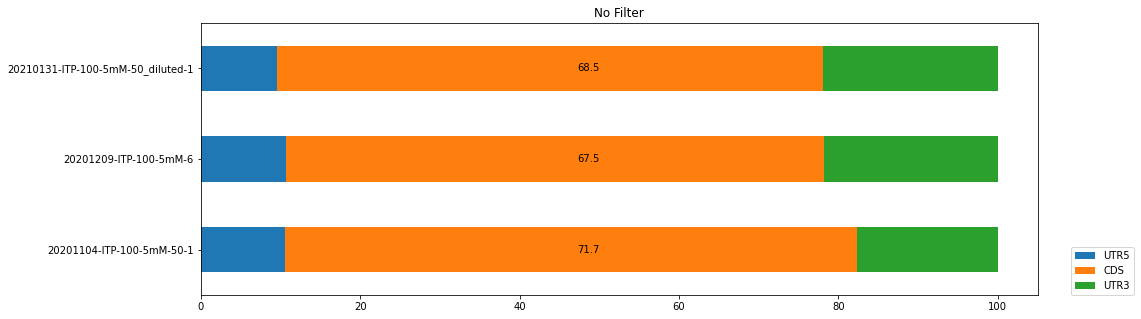

In [40]:
myribo.plot_region_counts( experiments = experiments_itp, 
                           range_lower = LENGTH_MIN, 
                          range_upper  = LENGTH_MAX,
                          title        = "No Filter");

## Inspection of 7 Transcripts

### CTC1

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


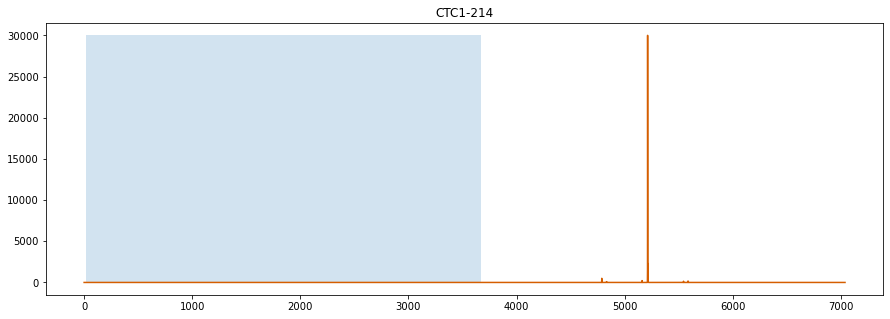

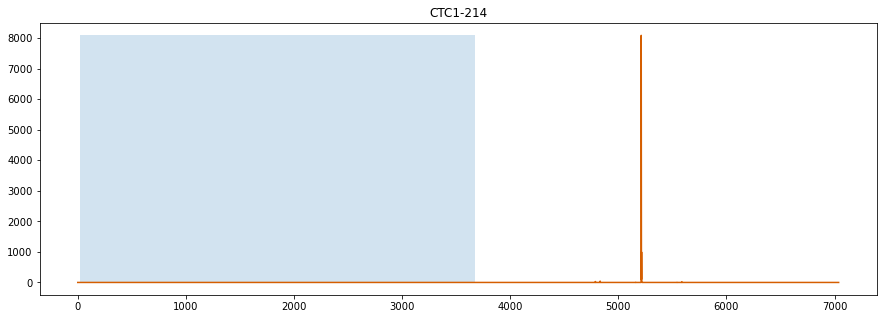

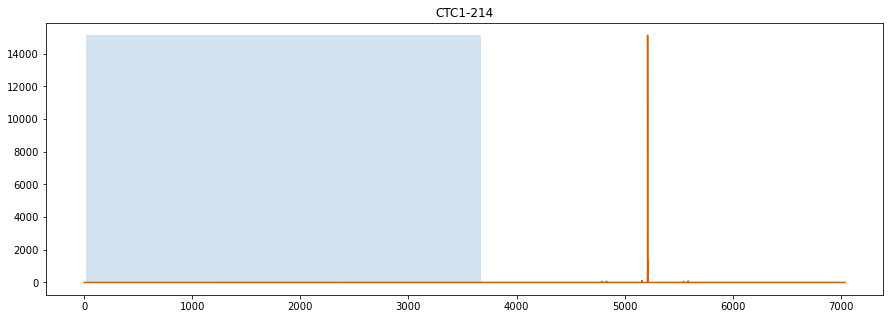

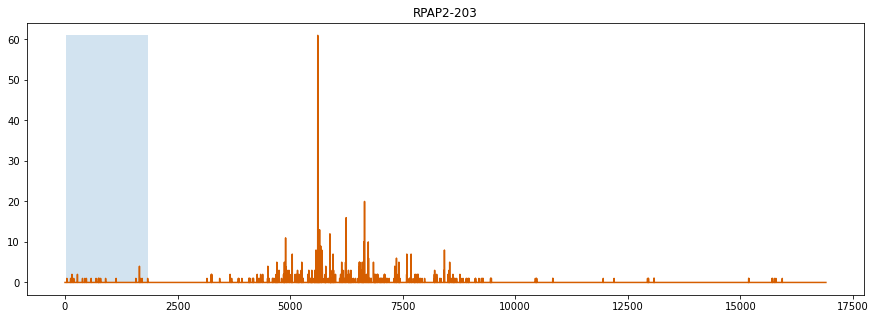

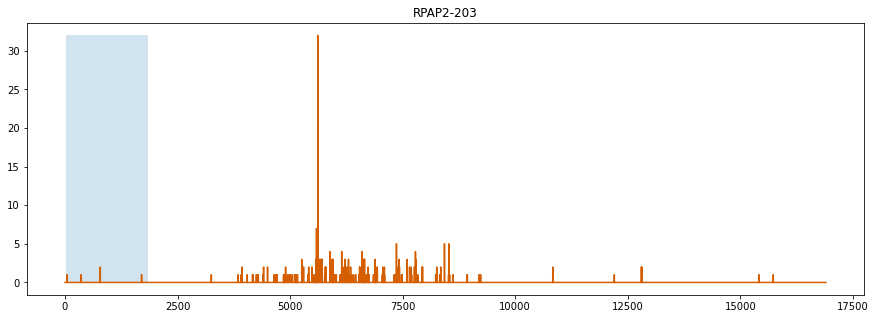

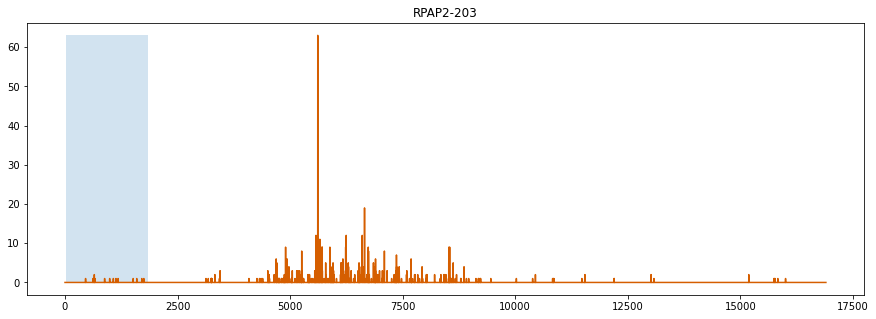

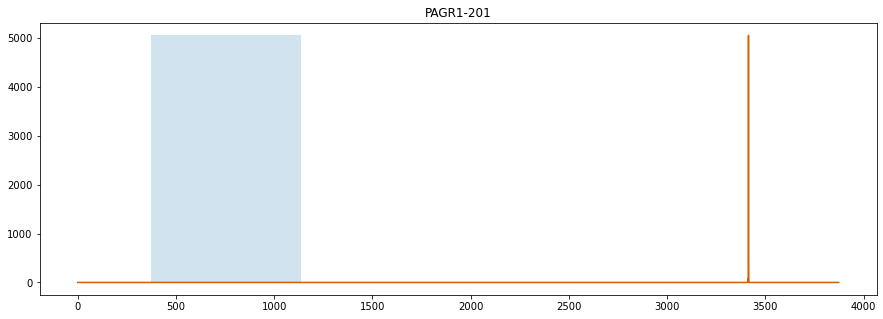

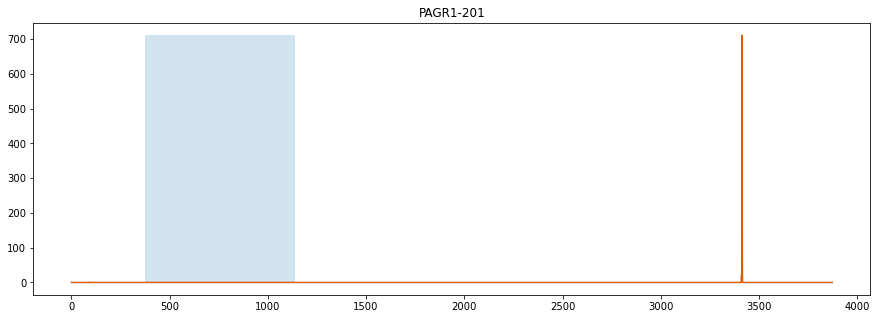

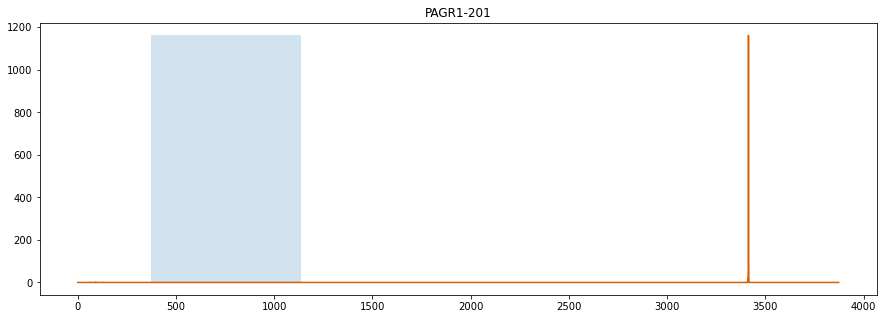

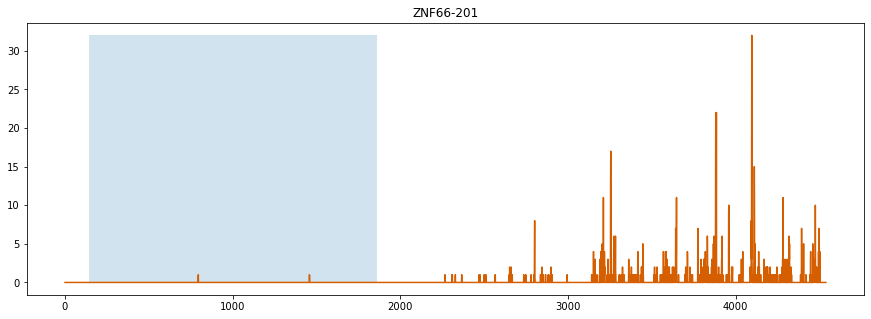

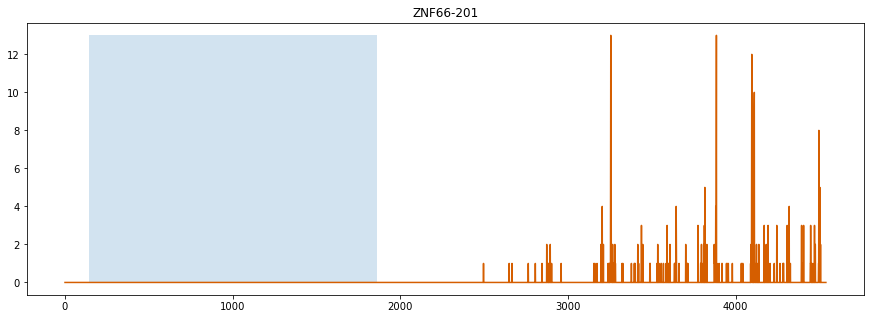

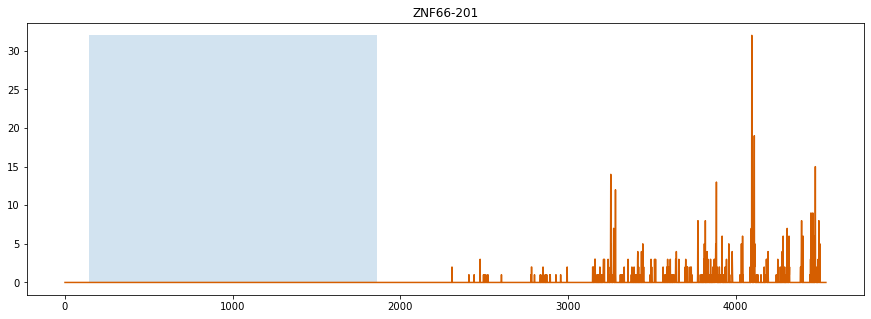

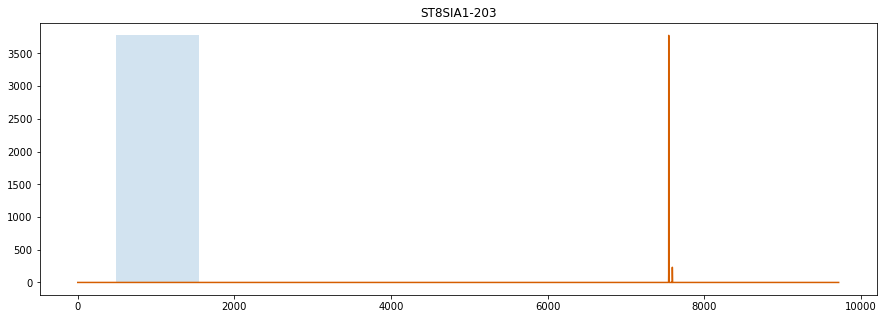

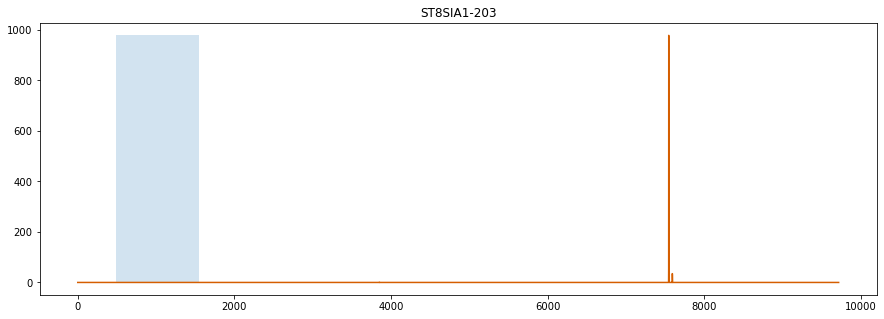

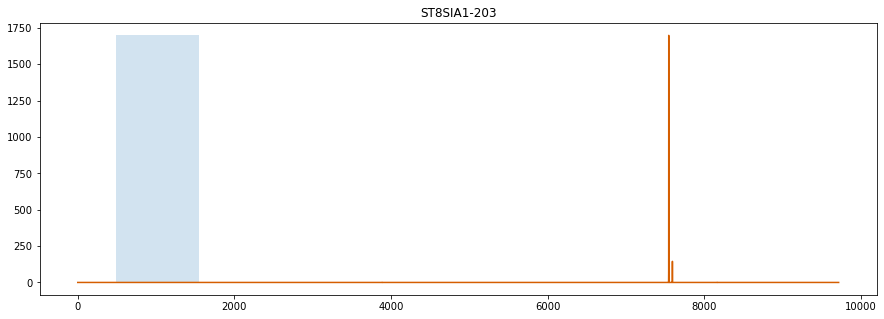

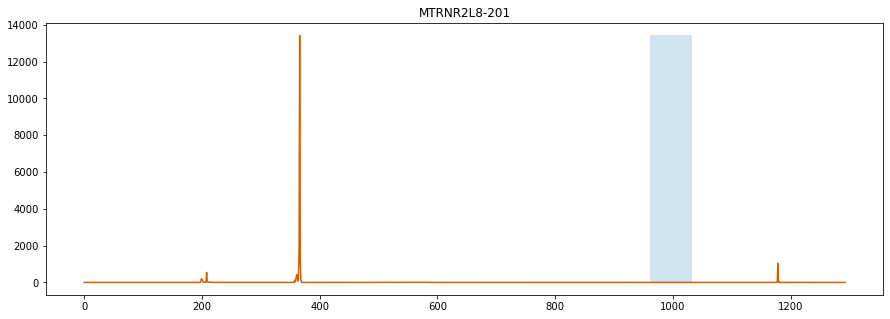

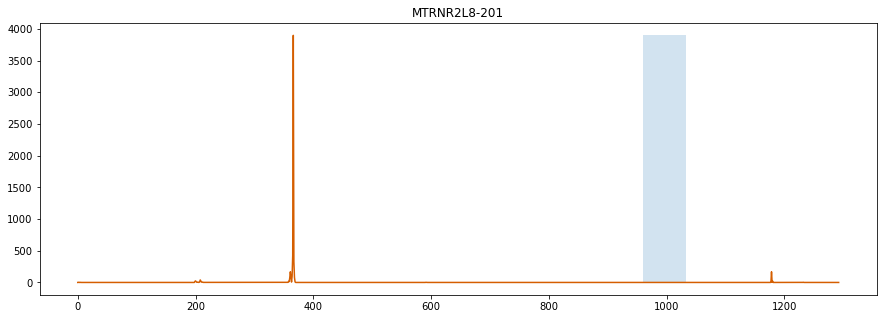

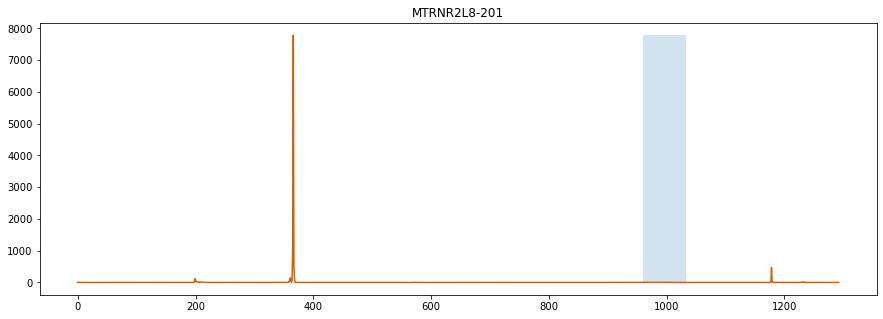

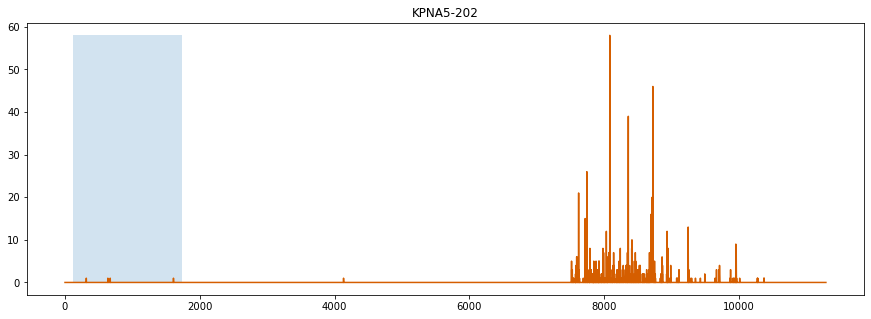

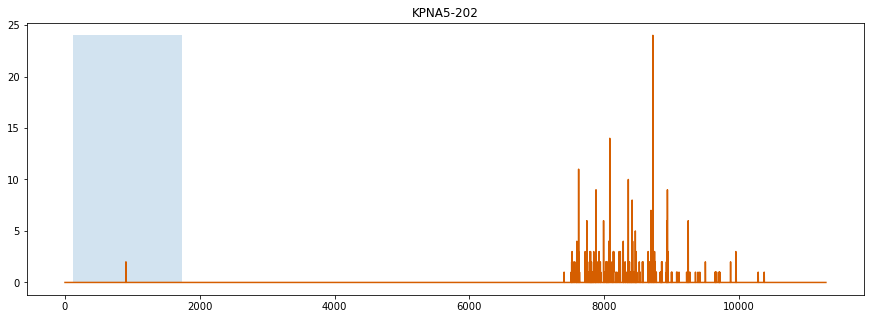

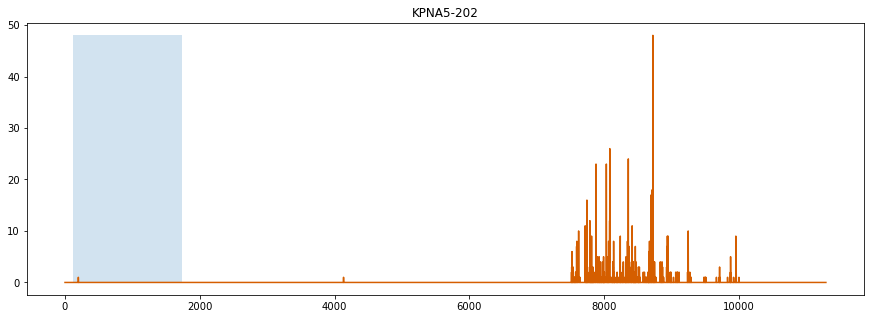

In [41]:

for t in list(top_7_transcripts):
    for e in experiments_itp:
        plot_gene(experiment_name = e, gene_name = t) 

## Read Fasta File

In [42]:

import gzip

class FastaEntry:
    '''
    Given a header and a sequence, creates a fasta entry.
    The string representation of the fasta entry consists
    of 50 nts per line.
    Do not change the chunk size (= 50)
    TODO : Consider making header and sequence properties
    Also consider putting more checks here for the input
    '''
    def __init__(self , header , sequence ):
        self.header   = header
        self.sequence = sequence

    def reverse_complement(self):
        complements = {"A" : "T" , "a" : "t" ,
                   "C" : "G" , "c" : "g" ,
                   "G" : "C" , "g" : "c" ,
                   "T" : "A" , "t" : "a" ,
                   "N" : "N" , "n" : "n"}
        result = list()

        for i in range(len(self.sequence) - 1 , -1 , -1 ):
            try:
                result.append(complements[self.sequence[i]])
            except IndexError:
                error_message = "Invalid character (%s) in the fasta sequence with header \n" \
                                "%s"%(self.sequence[i] , self.header)
                raise IOError(error_message)
        self.sequence = "".join(result)


    def __str__(self ):
        chunk_size                  = 50 # Do not change this!
        result_list                 = [ '>' +  self.header ]
        sequence_size               = len(self.sequence)
        number_of_remaining_letters = sequence_size
        number_of_processed_letters = 0

        while number_of_remaining_letters > 0:
            if number_of_remaining_letters <= chunk_size:
                result_list.append(self.sequence[ number_of_processed_letters : ])
                number_of_remaining_letters = 0
                number_of_processed_letters = sequence_size
            else:
                new_number_of_processed_letters = number_of_processed_letters + chunk_size
                result_list.append(self.sequence[ number_of_processed_letters : new_number_of_processed_letters])
                number_of_remaining_letters -= chunk_size
                number_of_processed_letters  = new_number_of_processed_letters

        return("\n".join( result_list ) )

############################################################################################


class FastaFile:
    '''
    This object is used to read fasta files into FastaEntry objects.
    For writing fasta files, we only need FastaEntry objects and using
    their str function, we can convert them to string and write to files.
    Note that it can be used as a context manager as well.
    '''

    def __init__(self , file):
        myopen = open
        if file.endswith(".gz"):
            myopen = gzip.open

        if(file):
            self.f = myopen(file , "rt")
        else:
            self.f = stdin

        self.current_header = ""
        self.current_sequence = list()

    #####################################################

    def __enter__(self):
        return self

    #####################################################

    def __exit__(self, exc_type, exc_val, exc_tb):
        pass


    ######################################################

    def __getitem__(self, index):

        for raw_line in self.f:
            line = raw_line.strip()
            if not line:
                continue

            if line[0] == ">":
                if not self.current_header:
                    self.current_header = (line[1:].split())[0]
                    self.current_sequence = list()
                else:
                    this_entry = FastaEntry(header = self.current_header , sequence = "".join(self.current_sequence) )
                    self.current_header = (line[1:].split())[0]
                    self.current_sequence = list()
                    return(this_entry)
            else:
                self.current_sequence.append(line)

        # this returns the last entry
        if len(self.current_sequence) > 0:
            this_entry = FastaEntry(header = self.current_header , sequence = "".join(self.current_sequence) )
            self.current_sequence = list()
            return(this_entry)

        raise IndexError

    #########################################################

    def __del__(self):
        self.f.close()

In [43]:
fasta_file = "../transcriptome_old_v2/appris_human_v2_selected.fa.gz"

In [44]:
myfasta = FastaFile(fasta_file)
transcript_sequences = {}

for e in myfasta:
    this_t = ribopy.api.alias.apris_human_alias(e.header)
    transcript_sequences[this_t] = e.sequence

In [45]:
transcript_sequences["RPAP2-203"][:10]

'AGACTACTCT'

In [46]:
transcript_sequences["RPAP2-203"].find("ACTATGTACCCACAAAAATTAAAAA")

13151

## Finding Sequences

In [47]:
# We will append sequences to this list and write them to our fasta file at the end.
fasta_entries = list()

### RPAP2

On the 3' UTR this gene has a stretch of repeat elements

It starts with the following the following repeat element:

>hg38_rmsk_L1MB8 range=chr1:92388060-92388259 5'pad=0 3'pad=0 strand=+ repeatMasking=none
TAGAATTAATCAAGTTCAGCAAGGTCACAGGCTAGATCAATATACAGAAA
ATCAATTGTATTTTTCTGTTCAGAAAACTCCAAAAATGAAATAAAGAAAA
TTGTGTTCACAATATCACCAAAGAGAATTAAATACTTAGGAATAAATTTA
ACAAAATAAGTATAAGACTTGTATAACGAAAACTATAAAACATTCAAGAG

The strectch goes until the following:

>hg38_rmsk_L1MA3 range=chr1:92398159-92398333 5'pad=0 3'pad=0 strand=+ repeatMasking=none
TTTTAAAATAACTGAAGAGTATAACTGGATTGTTTGTAACACAAAGGATA
AGTGCTTAAGATGATGGAAACCCTATTTATCCTGATGTGATTATTACACA
TTGCATGCCTGTACCAAAATATTTCATGTAACCCATAAATATATACATCT
ACTATGTACCCACAAAAATTAAAAA

In [48]:
transcript_sequences["RPAP2-203"].find("TAGAATTAATCAAGTTCAGCAAGGTCACAGGCTAGATCAATATACAGAAA")

2902

In [49]:
transcript_sequences["RPAP2-203"].find("ACTATGTACCCACAAAAATTAAAAA")

13151

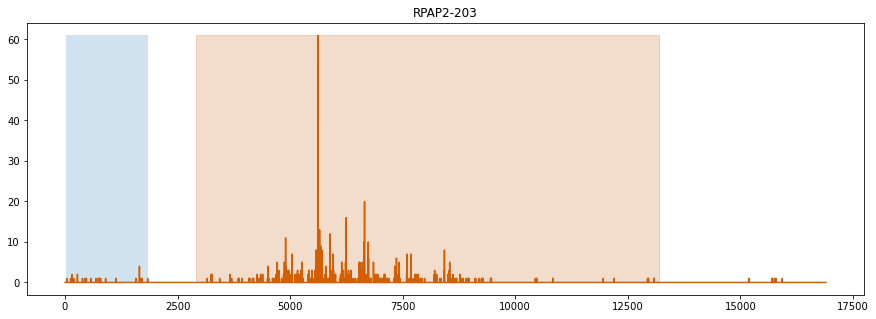

In [50]:
plot_gene(experiment_name = experiments_itp[0], gene_name = "RPAP2-203", highlight= [2902,13151 + 40]);

So we will exclude the highlighted region, which overlaps with repeat elements.
See also [genome browser](https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr1%3A92382839%2D92402325&hgsid=1127569041_yfKb1CIi2OyqmEiDaQlYTY44Cda2)

In [51]:
rpap2_header      = "hg38_rmsk_L1MB8_L1MA3_combined" 
rpap2_sequence    = transcript_sequences["RPAP2-203"][2902: (13151 + 40)]
rpap2_fasta_entry = FastaEntry(header = rpap2_header, sequence = rpap2_sequence)
fasta_entries.append(rpap2_fasta_entry)

## ST8SIA1-203

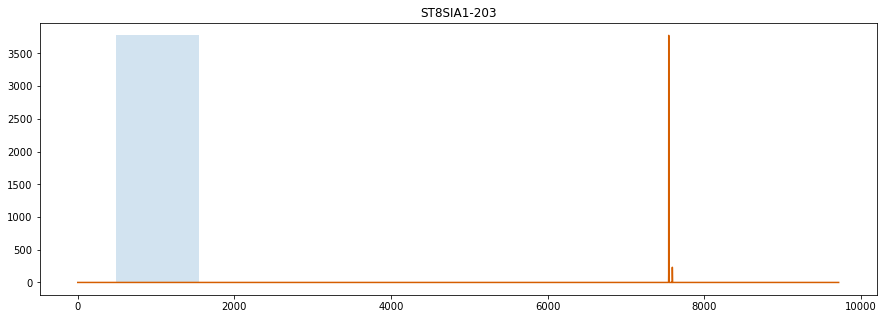

In [52]:
plot_gene(experiment_name = experiments_itp[0], gene_name = "ST8SIA1-203");

This peak overlaps with the following noncoding RNA:
(See also [Genome Browser](https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr12%3A22193391%2D22334714&hgsid=1127569041_yfKb1CIi2OyqmEiDaQlYTY44Cda2))

>ENST00000390870.1 (RNU1-149P) length=161
#########
TATCTTGTCATCCAGCTGTTATGGTTAATAATGAATAGTTTTCTCTGGGTGAAGCTTATC
CATTGCACACCTGATGTGCTGGCCCCTGCGATTTCCCCAAATGTTGGAATGTTGCCTGCA
TAATTTGTGGTAATGGGGGACTGTGTTCCTGCTTTTACCTG

In [53]:
transcript_sequences["ST8SIA1-203"].find("TATCTTGTCATCCAGCTGTTATGG")

7475

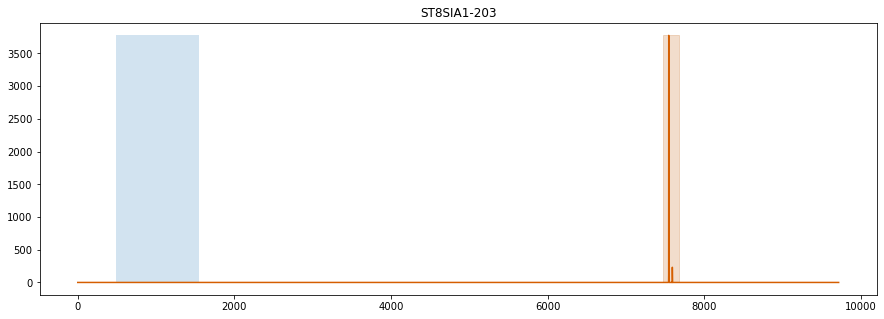

In [54]:
plot_gene(experiment_name = experiments_itp[0], gene_name = "ST8SIA1-203", highlight=[7475, 7636 + 40]);

In [55]:

st8sia1_header   = "ENST00000390870.1|RNU1-149P" 
st8sia1_sequence = transcript_sequences["ST8SIA1-203"][7475: 7636 + 40]
st8sia1_entry    = FastaEntry(header = st8sia1_header, sequence = st8sia1_sequence)

fasta_entries.append(st8sia1_entry)

## CTC1-214

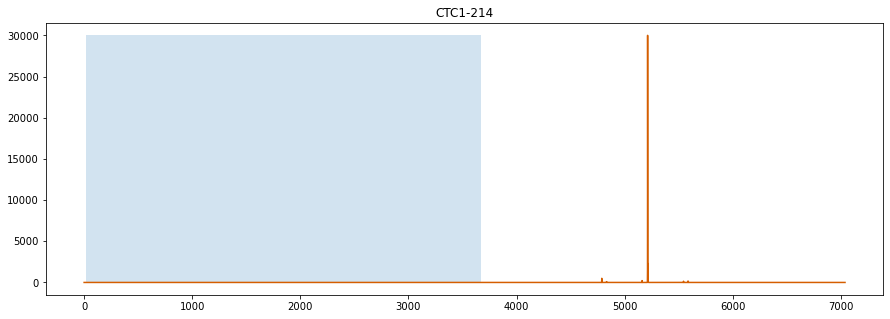

In [56]:
plot_gene(experiment_name = experiments_itp[0], gene_name = "CTC1-214");

This peak overlaps with the tRNA:

>hg38_rmsk_tRNA-Ser-TCY range=chr17:8226607-8226691 5'pad=0 3'pad=0 strand=- repeatMasking=none
#####################
GTAGTCGTGGCCGAGTGGTTAAGGCGATGGACTAGAAATCCATTGGGGTC
TCCCCGCGCAGGTTCGAATCCTGCCGACTACGTCA


See also [Genome Browser](https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr17%3A8224815%2D8248056&hgsid=1127569041_yfKb1CIi2OyqmEiDaQlYTY44Cda2)


Note that the other two overlapping tRNAs are on the other strand (+)

In [57]:
transcript_sequences["CTC1-214"].find("GTAGTCGTGGCCGAGTGGTT")

5162

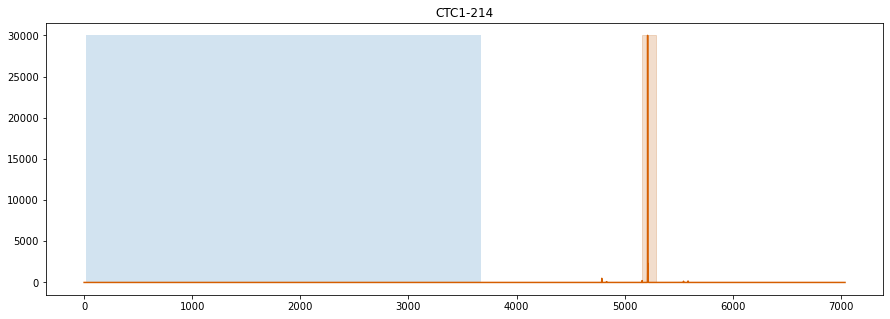

In [58]:
plot_gene(experiment_name = experiments_itp[0], gene_name = "CTC1-214", highlight=[ 5162, 5162 + 84 + 40 ]);

In [59]:
ctc1_header   = "hg38_rmsk_tRNA-Ser-TCY|chr17:8226607-8226731" 
ctc1_sequence = transcript_sequences["CTC1-214"][ 5162: 5162 + 84 + 40 ]
ctc1_entry    = FastaEntry( header = ctc1_header , sequence = ctc1_sequence) 

fasta_entries.append(ctc1_entry)

## KPNA5-202

This overlaps with the repeat element

>hg38_rmsk_L1PA3 range=chr6:116738085-116741007 5'pad=0 3'pad=0 strand=+ repeatMasking=none
###############################
AAAATTGACAGACCGTTAGCAAGACTAATAAAGAAGAAAAGAGAGAAGAA
TCAAATAGACGCAATAAAAAATGATAAAGGGGATATCACCACCGATCCCA
(Rest is removed for brevity)

See also [Genome Browser](https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr6%3A116731461%2D116742654&hgsid=1127569041_yfKb1CIi2OyqmEiDaQlYTY44Cda2)

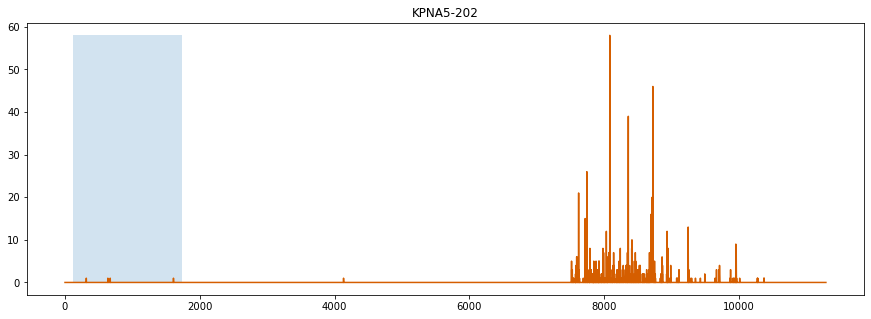

In [60]:
plot_gene(experiment_name = experiments_itp[0], gene_name = "KPNA5-202");

In [61]:
transcript_sequences["KPNA5-202"].find("AAAATTGACAGACCGTTAGCAAGACTAATAAAGAAGAAAAGAGAGAAGAA")

7505

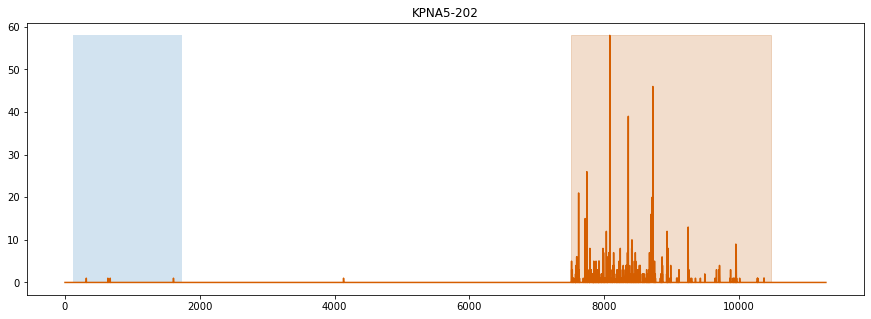

In [62]:
plot_gene(experiment_name = experiments_itp[0], gene_name = "KPNA5-202", highlight=[7505, 7505 + 2922 + 40]);

In [63]:
kpna5_header   = "hg38_rmsk_L1PA3|chr6:116738085-116741047" 
kpna5_sequence = transcript_sequences["KPNA5-202"][7505: 7505 + 2922 + 40]
kpna5_entry    = FastaEntry( header = kpna5_header, sequence = kpna5_sequence )

fasta_entries.append(kpna5_entry)

## PAGR-201

This peak overlaps with a repeat ALU element:

>hg38_rmsk_AluJr range=chr16:29821944-29822060 5'pad=0 3'pad=0 strand=+ repeatMasking=none
#######################################################
GGCTGGATGCGGTGGCTCAGGCCTGTAATCCCAGTACTTTGGGAGGCCCG
AATGGGAGGATGGCTTGAGGCCAGGAGTTCCAGACCAGCCTGAGCAACAT
AGCGAGACCCTGTCTCT

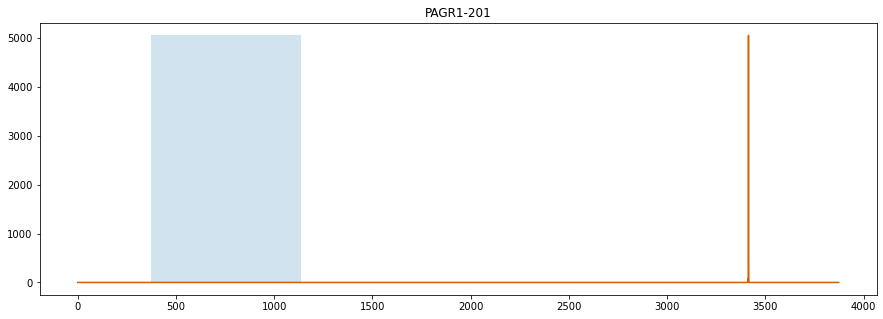

In [64]:
plot_gene(experiment_name = experiments_itp[0], gene_name = "PAGR1-201");

In [65]:
transcript_sequences["PAGR1-201"].find("GGCTGGATGCGGTGGCTCAGGCCTGTAATC")

3328

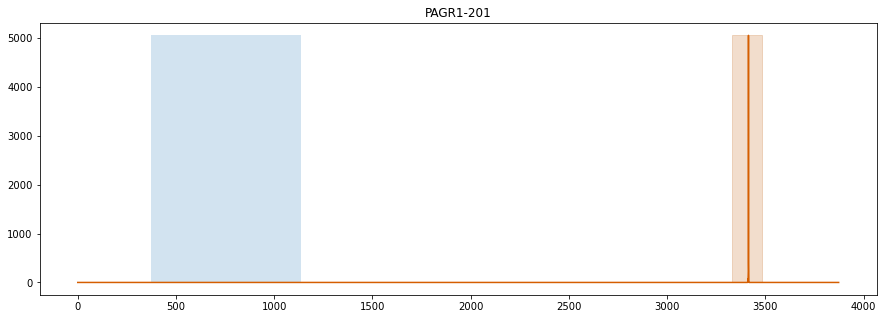

In [66]:
plot_gene(experiment_name = experiments_itp[0], gene_name = "PAGR1-201", highlight=[3328, 3328 + 116+40]);

In [67]:
pagr1_header   = "hg38_rmsk_AluJr|chr16:29821944-29822100" 
pagr1_sequence = transcript_sequences["PAGR1-201"][3328: 3328 + 116+40]
pagr1_entry    = FastaEntry(header = pagr1_header, sequence = pagr1_sequence)

fasta_entries.append(pagr1_entry)

## MTRNR2L8-201

**We decided to remove this transcript from our reference!**

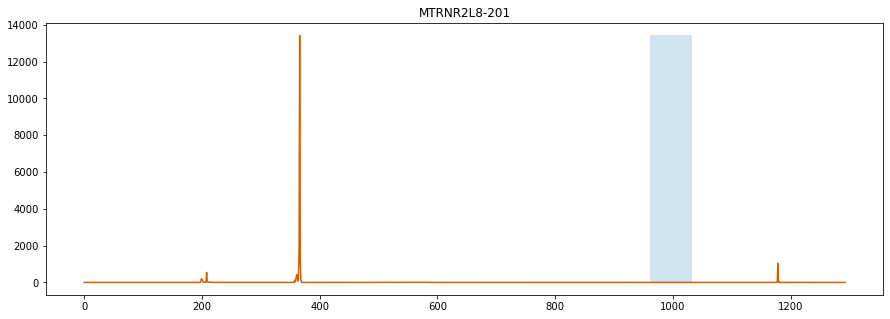

In [68]:
plot_gene(experiment_name = experiments_itp[0], gene_name = "MTRNR2L8-201");

In [69]:
transcript_sequences["MTRNR2L8-201"].find("AGAGGCACCG")

860

## ZNF66-201

This reagion overlaps with the following repeat element

>hg38_rmsk_L1PA3 range=chr19:20807725-20813827 5'pad=0 3'pad=0 strand=+ repeatMasking=none
###########################################################
GGGTGGAGCCAAGATGGCTGAATAGGTACAGCTCCTGTCTACAGCTCCCA
GCCTGAGCGACGCAGAAGATGGGTGATTTCTGCATTTCCGTCTGATGTAC
CAGGTTCATCTCACTAGGGAGTGCCAGACAGTGGCTGCAGGACAGTGGGT
GCAGTGCACTGTGCATGAGCTGAAGCAGGGCGAGGCATTGCCTCACTCAC
(Removed rest for brevity)

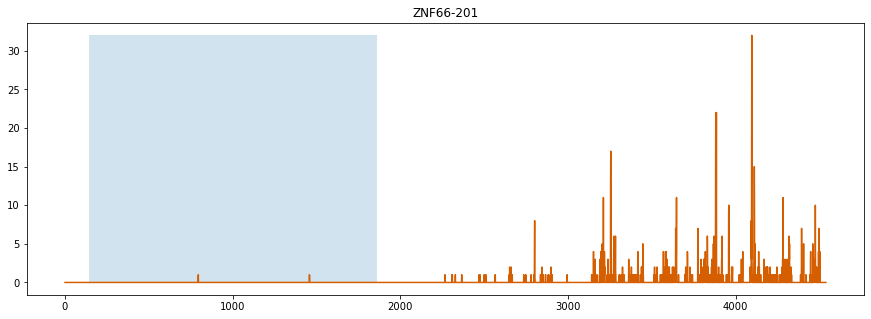

In [70]:
plot_gene(experiment_name = experiments_itp[0], gene_name = "ZNF66-201");

In [71]:
transcript_sequences["ZNF66-201"].find("GGGTGGAGCCAAGATGGCTGAATAGGTACAGCTCCTGTCTACAGCT")

2268

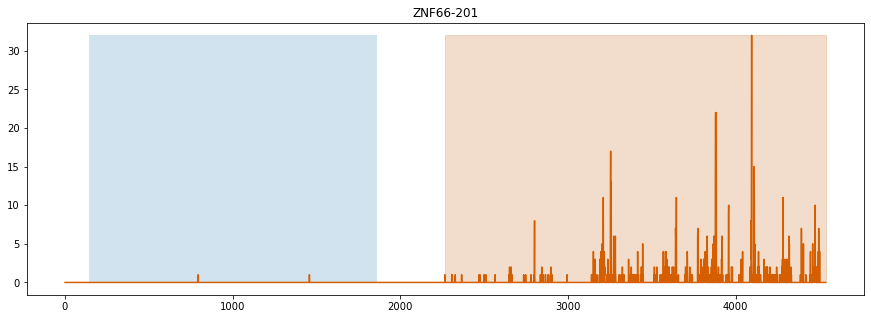

In [72]:
plot_gene(experiment_name = experiments_itp[0], gene_name = "ZNF66-201", highlight=[2268, len(transcript_sequences["ZNF66-201"]) ]);

In [73]:
znf66_header   = "hg38_rmsk_L1PA3|chr19:20807725-20813827" 
znf66_sequence = transcript_sequences["ZNF66-201"][2268:]
znf66_entry    = FastaEntry(header = znf66_header, sequence = znf66_sequence)

fasta_entries.append(znf66_entry) 

### Write Sequences to Fasta File

In [74]:
filter_fasta_path = "human_additional_filter.fa.gz"

with gzip.open(filter_fasta_path, "wt") as output_stream:
    for e in fasta_entries:
        print("Writing {}".format(e.header))
        print(e, file = output_stream)

Writing hg38_rmsk_L1MB8_L1MA3_combined
Writing ENST00000390870.1|RNU1-149P
Writing hg38_rmsk_tRNA-Ser-TCY|chr17:8226607-8226731
Writing hg38_rmsk_L1PA3|chr6:116738085-116741047
Writing hg38_rmsk_AluJr|chr16:29821944-29822100
Writing hg38_rmsk_L1PA3|chr19:20807725-20813827
